# HUẤN LUYỆN MODEL: TRAINING MODEL
##_Author_: **Nguyễn Phạm Thanh Phong - 21522458**
-Lớp  CS114.O21.KHCL
<br>
Model used:
* MobileNetV3 on split 1,3,4,5
* ResNet50 on split 2

## Import các thư viện cần thiết

In [ ]:
import os
import random
from datetime import datetime
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import json
import matplotlib.pyplot as plt
from torch.nn import Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Chuẩn bị các biến toàn cục

In [ ]:
label_mapping = {
    'Others': 0,
    'Honda': 1,
    'Suzuki': 2,
    'Yamaha': 3,
    'VinFast': 4
}
reverse_label_mapping={
    0: 'Others',
    1: 'Honda',
    2: 'Suzuki',
    3: 'Yamaha',
    4: 'VinFast'
}
ORIGINAL_THAYDUY_DIR = "drive/MyDrive/my_shared_shortcut/Public"

## Chuẩn bị dataset để load image:
Since torch.ImageFolder some how not work though loading image from cleaned set

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, df, save_dir, transform=None):
        self.df = df
        self.save_dir = save_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # print(self.df.iloc[idx]['full_path'])
        img_path = os.path.join(self.save_dir , self.df.iloc[idx]['full_path'])
        label = self.df.iloc[idx]['label_idx']

        # Open the image file
        image = Image.open(img_path).convert('RGB')

        # Apply transformation if provided
        if self.transform:
            image = self.transform(image)

        return image, label

## Load danh sách đường dẫn các ảnh và label tương ứng của chúng từ file ".csv" đã lưu từ trước

In [ ]:
df_path_1 = pd.read_csv('./SPLITS-CSV/MotocycleDataset-train-clean-1.csv')

In [ ]:
df_path_1.head(2)

,full_path,label_idx
0,./CLASS-IMAGES/Honda/22520968-22520996-2252099...,1
1,./CLASS-IMAGES/Honda/22520968-22520996-2252099...,1


In [ ]:
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])


In [ ]:
dataset = CustomImageDataset(df_path_1, save_dir='./', transform=transform)

## Hiển thị một vài ảnh từ Dataloader và iterator của Dataloader

In [ ]:
def show_images(images, labels, n_images=10, mapping={}):
    # Denormalize images if needed (assuming ToTensor() was used without normalization)
    # Convert from tensor (C, H, W) to numpy (H, W, C) and transpose dimensions
    images = images.permute(0, 2, 3, 1).numpy()

    # Create a figure to display the images
    fig, axes = plt.subplots(1, n_images, figsize=(15, 15))
    for i in range(n_images):
        image = images[i]
        label = mapping[labels[i].item()]
        # Show the image
        ax = axes[i]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(label)

    plt.show()

In [ ]:
data_loader_tranformed = DataLoader(dataset, batch_size=32, shuffle=True)
data_loader_tranformed

In [ ]:
data_iter_transformed = iter(data_loader_tranformed)
images, labels = next(data_iter_transformed)

### Xem một vài ảnh

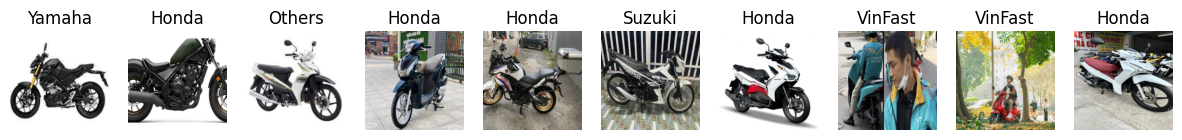

In [ ]:
show_images(images, labels, n_images=10,mapping=reverse_label_mapping)

## Chuẩn bị cho quá trình train

### Chuẩn bị EarlyStopping, nhằm ngừng train sau khi ghi nhận lại validation không cải thiện thêm nữa qua các lần train

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        # self.val_loss=1000

    def consume_loss(self, val_loss, model):
        print(f'in early: val_loss vs best_loss: {val_loss} - {self.best_loss}')
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(val_loss, model)
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')



### Hàm save_model sẽ lưu lại các thông số của model (model.state_dict()), cũng như các thước đo trong quá trình train model qua từng epoch
* model: model đã định nghĩa
* train_loader: [Dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) của training dataset
* val_loader: [Dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) của validation dataset
* criterion: một module cho phép tính toán loss qua từng epoch, ở đây ta sử dụng [Cross Entropyloss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
* optimizer: một module cho phép cập nhật gradient khi thực hiện [propagation](https://www.geeksforgeeks.org/what-is-forward-propagation-in-neural-networks/) và [backpropagation](https://www.geeksforgeeks.org/backpropagation-in-neural-network/) trên mỗi batch của [Dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
* scheduler: an util function, which is vitally support my learning rate updates over epochs, cause the success of this model training
* scheduler: một module thiết yếu giúp cập nhật learning rate sau các epoch train nếu vi phạm vào điều kiện và vượt quá patience của module. [Mô tả ở đây](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html)
* current_epoch: Epoch đang train hiện tại, dùng trong trường hợp bị hủy trong quá trình train và cần train tiếp tại epoch trước đó
* num_epochs: Số lượng epoch tối đa dùng cho quá trình train hiện tại
* checkpoint_savedir: đường dẫn để lưu model và các thước đo trong quá trình train


Qua thời gian, đoạn code sẽ giúp lưu lại model tốt nhất dựa trên tiêu chí validation loss, dừng theo điều kiện của EarlyStopping (patience) and và cuối cùng trả về model tốt nhất




In [ ]:
def save_model(model, epoch, train_loss, val_loss, train_acc, val_acc, checkpoint_savedir):
    save_dict = {
        "model": model.state_dict(),
        "val_loss": val_loss,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_acc": val_acc
    }
    checkpoint_path = os.path.join(checkpoint_savedir, f'epoch_{epoch}.pth')
    torch.save(save_dict, checkpoint_path)
    print(f"saved model at epoch {epoch}: {checkpoint_path}")

def train_model(model, train_loader:DataLoader, val_loader:DataLoader,
                criterion, optimizer, scheduler,current_epoch, num_epochs, checkpoint_savedir='./models', early_stopping=None):
    device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"device: {device}")
    model.to(device)

    best_loss = float('inf')
    train_size = len(train_loader.dataset)
    val_size = len(val_loader.dataset)
    print(f"train size: {train_size}")
    print(f"val size: {val_size}")

    for epoch in range(current_epoch,num_epochs+1):
        model.train()
        running_loss = 0.0

        # Training Phase
        train_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        train_acc = train_corrects*100 / train_size
        print(f"Training Loss: {epoch_loss:.6f} ; Acc: {train_acc:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / val_size
        val_acc = val_corrects*100 / val_size
        print(f"Validation Loss: {val_epoch_loss:.4f}; Acc: {val_acc:.4f}")

        # Update scheduler
        scheduler.step(val_epoch_loss)
        # Save checkpoint
        os.makedirs(checkpoint_savedir, exist_ok=True)
        save_model(model, epoch, epoch_loss, val_epoch_loss, train_acc, val_acc, checkpoint_savedir)

        if(early_stopping):
            early_stopping.consume_loss(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping!!!!!!!!!!!!!!!!!!")
                break

        # Save the best model based on validation loss
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_model_path = os.path.join(checkpoint_savedir, 'best_model.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model updated with validation loss {best_loss:.4f} and saved at {best_model_path}")

## Làm giàu dữ liệu ảnh trực tiếp trên training dataset

* Model sẽ cần nhận được nhiều biến thể hơn trong quá trình train, từ đó nâng cao khả năng trích xuất đặc trưng và nhận diện của model khi dự đoán các ảnh trên thực tế
* Validation dataset sẽ giả lập các ảnh sẽ dự đoán trong thực tế, do đó chỉ đơn giản nhận một vài biến đổi đơn giản, để đảm bảo model sẽ dự đoán ảnh trên cùng hệ quy chiếu
<br>
Lưu ý:
<br> Hệ quy chiếu ở đây chọn:
* Kích cỡ ảnh: IMG_SIZE=360
* Cắt phần trung tâm của ảnh: transforms.CenterCrop(IMG_SIZE-24) với IMG_SIZE=360
* Kiểu dữ liệu ảnh: [Tensor Image](https://pytorch.org/vision/main/generated/torchvision.tv_tensors.Image.html)
* Normalization: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).
<br>

Lý do vì sao nên normalize ảnh trước khi train nằm ở bài báo nghiên sau: [ImageNet Classification with Deep Convolutional Neural Networks ](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

In [ ]:
IMG_SIZE = 360
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE-24),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


## Bắt đầu train model

### Cấu hình model và chuẩn bị các hyper-parameter trước thực thi hàm train:
* Bằng cách in ra model [MobileNetV3](https://pytorch.org/vision/main/models/mobilenetv3.html), ta có thể thấy được layer cuối cùng của model
* Trong trường hợp này, ta có 5 lớp đại diện cho 5 label. Do đó, out_features của layer cuối cùng của model sẽ là 5
* Đồng thời, ta load các weights đã được train sẵn trước trong model [MobileNetV3](https://pytorch.org/vision/main/models/mobilenetv3.html)
* Các hyper-parameter dùng để tinh chỉnh trước khi train bao gồm:
 * criterion: module sẽ được dùng cho việc tính toán [Cross Entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
 * optimizer: sử dụng [ADAM optimizer](https://www.geeksforgeeks.org/adam-optimizer/) được mô tả trong phần "[Cơ sở lý thuyết](https://colab.research.google.com/drive/14ueaXjzvj-CbaopmHvJ2fTOaUCNs2hdq?authuser=1#scrollTo=GsJhcMshgEuy&line=1&uniqifier=1)" trên
 * scheduler: module giúp đưa ra quyết định update learning rate qua các epoch

Giải thích thêm về module Scheduler:
Các parameter khi dùng scheduler trong trường hợp này gồm:
<br>
* optimizer: Optimizer đã khai báo trước đó, nhằm bọc lấy module này
<br>
* mode: min. Vì ta sẽ chọn giá trị thấp nhất của validation loss làm điều kiện giảm trước khi train
<br>
* factor: hệ số sẽ được nhân cho learning rate khi thỏa mãn điều kiện của module
<br>
* patience: số lần chờ đợi khi điều kiện của module bị vi phạm
<br>

Chi tiết về module scheduler có thể xem ở đây [Reduce Lr On Plateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html)

In [ ]:
num_classes = 5  # Number of classes in your dataset
model = models.mobilenet_v3_large(weights='DEFAULT')
# print(model)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)
model.classifier = nn.Sequential(
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=5, bias=True)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Define criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
# early_stopping = EarlyStopping(patience=25, verbose=True)


cuda


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### Load danh sách đường dẫn các ảnh và label tương ứng của chúng thành Dataframe

In [ ]:
train_df = pd.read_csv('./split-1-train.csv')
val_df = pd.read_csv('./split-1-val.csv')

### Chuẩn bị Training Dataset và Validation Dataset.
#### Chuẩn bị DataLoader để load Image từ danh sách đường dẫn các ảnh đã chuẩn bị từ trước

In [ ]:
train_dataset = CustomImageDataset(train_df,save_dir='./',transform=train_transform)
val_dataset=CustomImageDataset(val_df,save_dir='./',transform=val_transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=6)

### Train model cho Split 1
* Số epoch sẽ train: 80
* epoch bắt đầu: 1
* train model từ các module đã chuẩn bị từ trước và sử dụng hàm train_model để train

In [ ]:
num_epochs=80
current_epoch = 1
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,current_epoch, num_epochs, checkpoint_savedir='./models')

device: cuda
train size: 22223
val size: 5556


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 1.251844 ; Acc: 46.7399


Validation Epoch 2/80:   1%|          | 2/174 [00:00<00:41,  4.14it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 2/80:  17%|█▋        | 30/174 [00:02<00:09, 15.77it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 2/80:  21%|██        | 36/174 [00:02<00:07, 17.95it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 2/80:  25%|██▌       | 44/174 [00:03<00:06, 19.21it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images wi

Validation Loss: 1.0017; Acc: 58.8553
saved model at epoch 1: ./models/epoch_1.pth
Best model updated with validation loss 1.0017 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.990243 ; Acc: 60.3429


Validation Epoch 3/80:   1%|          | 2/174 [00:00<00:40,  4.20it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 3/80:  17%|█▋        | 30/174 [00:02<00:08, 16.04it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 3/80:  21%|██        | 36/174 [00:02<00:07, 17.98it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 3/80:  25%|██▍       | 43/174 [00:02<00:06, 19.07it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images wi

Validation Loss: 0.8002; Acc: 68.9525
saved model at epoch 2: ./models/epoch_2.pth
Best model updated with validation loss 0.8002 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.866134 ; Acc: 65.7967


Validation Epoch 4/80:   1%|          | 2/174 [00:00<00:42,  4.03it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 4/80:  17%|█▋        | 30/174 [00:02<00:08, 16.64it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 4/80:  21%|██        | 36/174 [00:02<00:07, 18.33it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 4/80:  25%|██▌       | 44/174 [00:02<00:06, 19.28it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images wi

Validation Loss: 0.7520; Acc: 71.0223
saved model at epoch 3: ./models/epoch_3.pth
Best model updated with validation loss 0.7520 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.807132 ; Acc: 68.4336


Validation Epoch 5/80:   1%|          | 2/174 [00:00<00:40,  4.28it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 5/80:  17%|█▋        | 30/174 [00:02<00:08, 16.04it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 5/80:  21%|██        | 36/174 [00:02<00:07, 18.03it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 5/80:  25%|██▌       | 44/174 [00:02<00:06, 19.28it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images wi

Validation Loss: 0.6351; Acc: 76.5479
saved model at epoch 4: ./models/epoch_4.pth
Best model updated with validation loss 0.6351 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.750212 ; Acc: 71.1785


Validation Epoch 6/80:   1%|          | 2/174 [00:00<00:40,  4.30it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 6/80:  18%|█▊        | 32/174 [00:02<00:08, 16.96it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 6/80:  20%|██        | 35/174 [00:02<00:07, 17.93it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 6/80:  24%|██▍       | 42/174 [00:02<00:06, 19.30it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images wi

Validation Loss: 0.5939; Acc: 78.5097
saved model at epoch 5: ./models/epoch_5.pth
Best model updated with validation loss 0.5939 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.703381 ; Acc: 72.9064


Validation Epoch 7/80:   1%|          | 2/174 [00:00<00:41,  4.16it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 7/80:  18%|█▊        | 32/174 [00:02<00:08, 17.00it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 7/80:  20%|█▉        | 34/174 [00:02<00:07, 17.58it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 7/80:  24%|██▍       | 42/174 [00:02<00:06, 19.19it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images wi

Validation Loss: 0.5813; Acc: 78.5997
saved model at epoch 6: ./models/epoch_6.pth
Best model updated with validation loss 0.5813 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.671230 ; Acc: 74.3194


Validation Epoch 8/80:   1%|          | 2/174 [00:00<00:41,  4.14it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 8/80:  18%|█▊        | 31/174 [00:02<00:08, 16.51it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 8/80:  20%|██        | 35/174 [00:02<00:07, 17.81it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 8/80:  25%|██▌       | 44/174 [00:02<00:06, 19.32it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images wi

Validation Loss: 0.5882; Acc: 79.1937
saved model at epoch 7: ./models/epoch_7.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.626579 ; Acc: 76.2183


Validation Epoch 9/80:   1%|          | 2/174 [00:00<00:40,  4.30it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 9/80:  17%|█▋        | 30/174 [00:02<00:09, 15.76it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 9/80:  21%|██        | 36/174 [00:02<00:07, 17.82it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 9/80:  24%|██▍       | 42/174 [00:02<00:06, 18.89it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images wi

Validation Loss: 0.5437; Acc: 81.5515
saved model at epoch 8: ./models/epoch_8.pth
Best model updated with validation loss 0.5437 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.602880 ; Acc: 77.2263


Validation Epoch 10/80:   2%|▏         | 3/174 [00:00<00:28,  6.11it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 10/80:  18%|█▊        | 32/174 [00:02<00:08, 16.74it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 10/80:  20%|█▉        | 34/174 [00:02<00:08, 17.49it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 10/80:  25%|██▍       | 43/174 [00:02<00:06, 19.19it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5348; Acc: 81.4075
saved model at epoch 9: ./models/epoch_9.pth
Best model updated with validation loss 0.5348 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.579442 ; Acc: 78.0723


Validation Epoch 11/80:   1%|          | 2/174 [00:00<00:41,  4.15it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 11/80:  17%|█▋        | 30/174 [00:02<00:09, 15.77it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 11/80:  20%|██        | 35/174 [00:02<00:07, 17.56it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 11/80:  24%|██▍       | 42/174 [00:02<00:06, 18.97it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5137; Acc: 82.4514
saved model at epoch 10: ./models/epoch_10.pth
Best model updated with validation loss 0.5137 and saved at ./models/best_model.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.562678 ; Acc: 78.4323


Validation Epoch 12/80:   1%|          | 2/174 [00:00<00:40,  4.30it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 12/80:  18%|█▊        | 32/174 [00:02<00:08, 16.73it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 12/80:  21%|██        | 36/174 [00:02<00:07, 18.00it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 12/80:  25%|██▍       | 43/174 [00:02<00:06, 19.10it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5123; Acc: 83.2613
saved model at epoch 11: ./models/epoch_11.pth
Best model updated with validation loss 0.5123 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.545088 ; Acc: 79.2377


Validation Epoch 13/80:   2%|▏         | 3/174 [00:00<00:28,  6.07it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 13/80:  18%|█▊        | 32/174 [00:02<00:08, 16.80it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 13/80:  21%|██        | 36/174 [00:02<00:07, 18.03it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 13/80:  25%|██▍       | 43/174 [00:02<00:06, 19.22it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4911; Acc: 83.4953
saved model at epoch 12: ./models/epoch_12.pth
Best model updated with validation loss 0.4911 and saved at ./models/best_model.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.524275 ; Acc: 80.5697


Validation Epoch 14/80:   1%|          | 2/174 [00:00<00:40,  4.21it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 14/80:  18%|█▊        | 32/174 [00:02<00:08, 16.87it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 14/80:  20%|█▉        | 34/174 [00:02<00:07, 17.56it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 14/80:  25%|██▍       | 43/174 [00:02<00:06, 19.19it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4849; Acc: 84.2513
saved model at epoch 13: ./models/epoch_13.pth
Best model updated with validation loss 0.4849 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.504535 ; Acc: 81.1097


Validation Epoch 15/80:   2%|▏         | 3/174 [00:00<00:27,  6.13it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 15/80:  18%|█▊        | 32/174 [00:02<00:08, 16.79it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 15/80:  21%|██        | 36/174 [00:02<00:07, 17.98it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 15/80:  24%|██▍       | 42/174 [00:02<00:06, 19.08it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4935; Acc: 83.6753
saved model at epoch 14: ./models/epoch_14.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.495345 ; Acc: 81.2402


Validation Epoch 16/80:   1%|          | 2/174 [00:00<00:40,  4.29it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 16/80:  18%|█▊        | 32/174 [00:02<00:08, 16.84it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 16/80:  20%|█▉        | 34/174 [00:02<00:08, 17.48it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 16/80:  25%|██▍       | 43/174 [00:02<00:06, 19.17it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5035; Acc: 83.2253
saved model at epoch 15: ./models/epoch_15.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.480113 ; Acc: 82.1176


Validation Epoch 17/80:   1%|          | 2/174 [00:00<00:40,  4.25it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 17/80:  18%|█▊        | 32/174 [00:02<00:08, 16.58it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 17/80:  20%|█▉        | 34/174 [00:02<00:08, 17.33it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 17/80:  25%|██▍       | 43/174 [00:02<00:06, 19.16it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5137; Acc: 82.9194
saved model at epoch 16: ./models/epoch_16.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.460377 ; Acc: 82.8151


Validation Epoch 18/80:   1%|          | 2/174 [00:00<00:40,  4.28it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 18/80:  18%|█▊        | 32/174 [00:02<00:08, 16.62it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 18/80:  20%|█▉        | 34/174 [00:02<00:08, 17.35it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 18/80:  24%|██▍       | 42/174 [00:02<00:06, 19.05it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4794; Acc: 85.2772
saved model at epoch 17: ./models/epoch_17.pth
Best model updated with validation loss 0.4794 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.440766 ; Acc: 83.7286


Validation Epoch 19/80:   1%|          | 1/174 [00:00<01:14,  2.33it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 19/80:  18%|█▊        | 31/174 [00:02<00:08, 16.21it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 19/80:  21%|██        | 36/174 [00:02<00:07, 18.08it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 19/80:  25%|██▍       | 43/174 [00:02<00:06, 19.14it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4822; Acc: 85.0792
saved model at epoch 18: ./models/epoch_18.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.432517 ; Acc: 83.7691


Validation Epoch 20/80:   1%|          | 2/174 [00:00<00:40,  4.20it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 20/80:  18%|█▊        | 32/174 [00:02<00:08, 16.38it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 20/80:  20%|█▉        | 34/174 [00:02<00:08, 17.15it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 20/80:  25%|██▍       | 43/174 [00:02<00:06, 19.05it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4915; Acc: 85.1332
saved model at epoch 19: ./models/epoch_19.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.423948 ; Acc: 84.0346


Validation Epoch 21/80:   1%|          | 2/174 [00:00<00:39,  4.35it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 21/80:  18%|█▊        | 32/174 [00:02<00:08, 16.74it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 21/80:  20%|█▉        | 34/174 [00:02<00:08, 17.47it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 21/80:  25%|██▌       | 44/174 [00:02<00:06, 19.29it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4812; Acc: 85.4932
saved model at epoch 20: ./models/epoch_20.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.410851 ; Acc: 84.5160


Validation Epoch 22/80:   2%|▏         | 3/174 [00:00<00:28,  6.11it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 22/80:  18%|█▊        | 32/174 [00:02<00:08, 16.89it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 22/80:  21%|██        | 36/174 [00:02<00:07, 18.03it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 22/80:  24%|██▍       | 42/174 [00:02<00:06, 19.03it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4728; Acc: 85.7631
saved model at epoch 21: ./models/epoch_21.pth
Best model updated with validation loss 0.4728 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.399485 ; Acc: 84.8985


Validation Epoch 23/80:   1%|          | 2/174 [00:00<00:41,  4.11it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 23/80:  17%|█▋        | 30/174 [00:02<00:09, 15.88it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 23/80:  21%|██        | 36/174 [00:02<00:07, 17.96it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 23/80:  25%|██▍       | 43/174 [00:02<00:06, 19.07it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5017; Acc: 85.4572
saved model at epoch 22: ./models/epoch_22.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.398068 ; Acc: 85.3260


Validation Epoch 24/80:   1%|          | 2/174 [00:00<00:41,  4.10it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 24/80:  18%|█▊        | 31/174 [00:02<00:08, 16.20it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 24/80:  21%|██        | 36/174 [00:02<00:07, 17.88it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 24/80:  25%|██▍       | 43/174 [00:02<00:06, 19.01it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4767; Acc: 86.3391
saved model at epoch 23: ./models/epoch_23.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.381378 ; Acc: 85.7805


Validation Epoch 25/80:   1%|          | 2/174 [00:00<00:42,  4.08it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 25/80:  18%|█▊        | 32/174 [00:02<00:08, 17.03it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 25/80:  21%|██        | 36/174 [00:02<00:07, 18.19it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 25/80:  25%|██▌       | 44/174 [00:02<00:06, 19.24it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5113; Acc: 85.9071
saved model at epoch 24: ./models/epoch_24.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.381484 ; Acc: 85.7130


Validation Epoch 26/80:   1%|          | 2/174 [00:00<00:41,  4.14it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 26/80:  17%|█▋        | 30/174 [00:02<00:09, 15.52it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 26/80:  20%|██        | 35/174 [00:02<00:08, 17.34it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 26/80:  25%|██▍       | 43/174 [00:03<00:06, 18.99it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4987; Acc: 85.8351
saved model at epoch 25: ./models/epoch_25.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.370803 ; Acc: 86.1225


Validation Epoch 27/80:   1%|          | 2/174 [00:00<00:39,  4.32it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 27/80:  17%|█▋        | 30/174 [00:02<00:09, 15.98it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 27/80:  21%|██        | 36/174 [00:02<00:07, 17.91it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 27/80:  24%|██▍       | 42/174 [00:02<00:07, 18.71it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4694; Acc: 86.4831
saved model at epoch 26: ./models/epoch_26.pth
Best model updated with validation loss 0.4694 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.354531 ; Acc: 86.9910


Validation Epoch 28/80:   1%|          | 2/174 [00:00<00:41,  4.13it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 28/80:  17%|█▋        | 30/174 [00:02<00:09, 15.93it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 28/80:  20%|██        | 35/174 [00:02<00:07, 17.62it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 28/80:  25%|██▍       | 43/174 [00:02<00:06, 19.08it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4946; Acc: 85.9251
saved model at epoch 27: ./models/epoch_27.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.361575 ; Acc: 86.5860


Validation Epoch 29/80:   1%|          | 2/174 [00:00<00:42,  4.09it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 29/80:  17%|█▋        | 30/174 [00:02<00:08, 16.03it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 29/80:  20%|██        | 35/174 [00:02<00:07, 17.70it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 29/80:  25%|██▍       | 43/174 [00:02<00:06, 19.19it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4879; Acc: 86.2311
saved model at epoch 28: ./models/epoch_28.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.351642 ; Acc: 86.9325


Validation Epoch 30/80:   2%|▏         | 3/174 [00:00<00:27,  6.18it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 30/80:  17%|█▋        | 30/174 [00:02<00:09, 15.91it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 30/80:  21%|██        | 36/174 [00:02<00:07, 17.87it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 30/80:  25%|██▍       | 43/174 [00:02<00:06, 19.01it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4601; Acc: 86.4111
saved model at epoch 29: ./models/epoch_29.pth
Best model updated with validation loss 0.4601 and saved at ./models/best_model.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.338776 ; Acc: 87.4814


Validation Epoch 31/80:   1%|          | 2/174 [00:00<00:41,  4.19it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 31/80:  18%|█▊        | 32/174 [00:02<00:08, 16.88it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 31/80:  21%|██        | 36/174 [00:02<00:07, 18.11it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 31/80:  25%|██▌       | 44/174 [00:02<00:06, 19.16it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4782; Acc: 86.4471
saved model at epoch 30: ./models/epoch_30.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.332655 ; Acc: 87.9359


Validation Epoch 32/80:   1%|          | 2/174 [00:00<00:41,  4.11it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 32/80:  18%|█▊        | 32/174 [00:02<00:08, 16.88it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 32/80:  21%|██        | 36/174 [00:02<00:07, 18.14it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 32/80:  26%|██▌       | 45/174 [00:03<00:06, 19.33it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4923; Acc: 86.0511
saved model at epoch 31: ./models/epoch_31.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.324286 ; Acc: 87.8099


Validation Epoch 33/80:   1%|          | 2/174 [00:00<00:41,  4.10it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 33/80:  17%|█▋        | 30/174 [00:02<00:09, 15.75it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 33/80:  21%|██        | 36/174 [00:02<00:07, 17.84it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 33/80:  25%|██▌       | 44/174 [00:03<00:06, 19.13it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5246; Acc: 85.9791
saved model at epoch 32: ./models/epoch_32.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.317767 ; Acc: 87.9989


Validation Epoch 34/80:   1%|          | 2/174 [00:00<00:40,  4.21it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 34/80:  18%|█▊        | 31/174 [00:02<00:08, 16.78it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 34/80:  20%|██        | 35/174 [00:02<00:07, 18.11it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 34/80:  25%|██▌       | 44/174 [00:02<00:06, 19.39it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4878; Acc: 86.8251
saved model at epoch 33: ./models/epoch_33.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.312030 ; Acc: 88.3904


Validation Epoch 35/80:   1%|          | 2/174 [00:00<00:42,  4.08it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 35/80:  18%|█▊        | 32/174 [00:02<00:08, 16.84it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 35/80:  20%|█▉        | 34/174 [00:02<00:08, 17.46it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 35/80:  25%|██▍       | 43/174 [00:02<00:06, 19.05it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5088; Acc: 86.8430
saved model at epoch 34: ./models/epoch_34.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.318819 ; Acc: 87.9629


Validation Epoch 36/80:   1%|          | 2/174 [00:00<00:40,  4.25it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 36/80:  18%|█▊        | 32/174 [00:02<00:08, 16.67it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 36/80:  21%|██        | 36/174 [00:02<00:07, 17.96it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 36/80:  25%|██▍       | 43/174 [00:02<00:06, 19.04it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5181; Acc: 86.0511
saved model at epoch 35: ./models/epoch_35.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.306645 ; Acc: 88.8134


Validation Epoch 37/80:   1%|          | 2/174 [00:00<00:41,  4.12it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 37/80:  17%|█▋        | 30/174 [00:02<00:09, 15.92it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 37/80:  21%|██        | 36/174 [00:02<00:07, 17.90it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 37/80:  25%|██▍       | 43/174 [00:02<00:06, 18.92it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4827; Acc: 86.8610
saved model at epoch 36: ./models/epoch_36.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.309547 ; Acc: 88.5794


Validation Epoch 38/80:   1%|          | 2/174 [00:00<00:40,  4.27it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 38/80:  17%|█▋        | 30/174 [00:02<00:09, 15.53it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 38/80:  21%|██        | 36/174 [00:02<00:07, 17.75it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 38/80:  24%|██▍       | 42/174 [00:02<00:07, 18.73it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5157; Acc: 86.5371
saved model at epoch 37: ./models/epoch_37.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.295404 ; Acc: 89.0969


Validation Epoch 39/80:   1%|          | 2/174 [00:00<00:40,  4.21it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 39/80:  18%|█▊        | 32/174 [00:02<00:08, 17.07it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 39/80:  20%|█▉        | 34/174 [00:02<00:07, 17.72it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 39/80:  25%|██▌       | 44/174 [00:02<00:06, 19.29it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5045; Acc: 87.2390
saved model at epoch 38: ./models/epoch_38.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.300927 ; Acc: 89.0069


Validation Epoch 40/80:   1%|          | 2/174 [00:00<00:42,  4.05it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 40/80:  18%|█▊        | 32/174 [00:02<00:08, 17.11it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 40/80:  20%|█▉        | 34/174 [00:02<00:07, 17.73it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 40/80:  25%|██▍       | 43/174 [00:02<00:06, 19.25it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5370; Acc: 86.5551
saved model at epoch 39: ./models/epoch_39.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.286571 ; Acc: 89.3624


Validation Epoch 41/80:   1%|          | 2/174 [00:00<00:43,  3.99it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 41/80:  17%|█▋        | 30/174 [00:02<00:08, 16.30it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 41/80:  20%|██        | 35/174 [00:02<00:07, 17.85it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 41/80:  25%|██▍       | 43/174 [00:02<00:06, 19.12it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5137; Acc: 87.0050
saved model at epoch 40: ./models/epoch_40.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.273411 ; Acc: 89.8484


Validation Epoch 42/80:   1%|          | 2/174 [00:00<00:41,  4.18it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 42/80:  18%|█▊        | 32/174 [00:02<00:08, 16.58it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 42/80:  20%|█▉        | 34/174 [00:02<00:08, 17.29it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 42/80:  25%|██▍       | 43/174 [00:02<00:06, 19.13it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4903; Acc: 87.6530
saved model at epoch 41: ./models/epoch_41.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.258755 ; Acc: 90.1768


Validation Epoch 43/80:   1%|          | 2/174 [00:00<00:42,  4.08it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 43/80:  19%|█▉        | 33/174 [00:02<00:08, 17.14it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 43/80:  20%|██        | 35/174 [00:02<00:07, 17.73it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 43/80:  24%|██▍       | 42/174 [00:02<00:06, 19.14it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4911; Acc: 87.8870
saved model at epoch 42: ./models/epoch_42.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.254247 ; Acc: 90.5728


Validation Epoch 44/80:   2%|▏         | 3/174 [00:00<00:27,  6.11it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 44/80:  18%|█▊        | 32/174 [00:02<00:08, 16.80it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 44/80:  20%|█▉        | 34/174 [00:02<00:08, 17.37it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 44/80:  24%|██▍       | 42/174 [00:02<00:06, 18.91it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4944; Acc: 87.6350
saved model at epoch 43: ./models/epoch_43.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.255258 ; Acc: 90.6763


Validation Epoch 45/80:   2%|▏         | 3/174 [00:00<00:28,  6.09it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 45/80:  18%|█▊        | 31/174 [00:02<00:08, 16.04it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 45/80:  21%|██        | 36/174 [00:02<00:07, 17.81it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 45/80:  25%|██▍       | 43/174 [00:02<00:06, 19.07it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4915; Acc: 87.9410
saved model at epoch 44: ./models/epoch_44.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.245251 ; Acc: 90.8833


Validation Epoch 46/80:   1%|          | 2/174 [00:00<00:40,  4.28it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 46/80:  17%|█▋        | 30/174 [00:02<00:09, 15.92it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 46/80:  20%|██        | 35/174 [00:02<00:07, 17.69it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 46/80:  24%|██▍       | 42/174 [00:02<00:06, 19.04it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4965; Acc: 87.9050
saved model at epoch 45: ./models/epoch_45.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.248454 ; Acc: 90.9238


Validation Epoch 47/80:   1%|          | 2/174 [00:00<00:40,  4.30it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 47/80:  18%|█▊        | 32/174 [00:02<00:08, 16.63it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 47/80:  20%|█▉        | 34/174 [00:02<00:08, 17.31it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 47/80:  25%|██▍       | 43/174 [00:02<00:06, 19.05it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.4920; Acc: 87.9410
saved model at epoch 46: ./models/epoch_46.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.236598 ; Acc: 91.2343


Validation Epoch 48/80:   2%|▏         | 3/174 [00:00<00:28,  6.09it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 48/80:  18%|█▊        | 32/174 [00:02<00:08, 16.60it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 48/80:  21%|██        | 36/174 [00:02<00:07, 17.97it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 48/80:  25%|██▍       | 43/174 [00:02<00:06, 19.24it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5017; Acc: 87.9410
saved model at epoch 47: ./models/epoch_47.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.242162 ; Acc: 90.8473


Validation Epoch 49/80:   1%|          | 2/174 [00:00<00:39,  4.33it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 49/80:  18%|█▊        | 31/174 [00:02<00:08, 16.66it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 49/80:  20%|██        | 35/174 [00:02<00:07, 17.99it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 49/80:  25%|██▍       | 43/174 [00:02<00:06, 19.16it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5068; Acc: 87.8690
saved model at epoch 48: ./models/epoch_48.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.231365 ; Acc: 91.3513


Validation Epoch 50/80:   1%|          | 2/174 [00:00<00:41,  4.16it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 50/80:  18%|█▊        | 31/174 [00:02<00:08, 16.79it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 50/80:  21%|██        | 36/174 [00:02<00:07, 18.30it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 50/80:  25%|██▍       | 43/174 [00:02<00:06, 19.11it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5082; Acc: 87.8690
saved model at epoch 49: ./models/epoch_49.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.234688 ; Acc: 91.3513


Validation Epoch 51/80:   1%|          | 2/174 [00:00<00:39,  4.30it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 51/80:  18%|█▊        | 32/174 [00:02<00:08, 16.80it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 51/80:  21%|██        | 36/174 [00:02<00:07, 18.05it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 51/80:  24%|██▍       | 42/174 [00:02<00:06, 19.03it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5061; Acc: 87.8150
saved model at epoch 50: ./models/epoch_50.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.233163 ; Acc: 91.3828


Validation Epoch 52/80:   2%|▏         | 3/174 [00:00<00:28,  6.04it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 52/80:  17%|█▋        | 30/174 [00:02<00:09, 15.72it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 52/80:  21%|██        | 36/174 [00:02<00:07, 17.84it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 52/80:  25%|██▍       | 43/174 [00:02<00:06, 18.94it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5102; Acc: 87.7970
saved model at epoch 51: ./models/epoch_51.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.238943 ; Acc: 91.1353


Validation Epoch 53/80:   1%|          | 2/174 [00:00<00:40,  4.26it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 53/80:  18%|█▊        | 32/174 [00:02<00:08, 16.66it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 53/80:  21%|██        | 36/174 [00:02<00:07, 17.90it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 53/80:  24%|██▍       | 42/174 [00:02<00:06, 18.94it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5048; Acc: 87.9590
saved model at epoch 52: ./models/epoch_52.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.228827 ; Acc: 91.5673


Validation Epoch 54/80:   1%|          | 1/174 [00:00<01:16,  2.27it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 54/80:  18%|█▊        | 32/174 [00:02<00:08, 16.67it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 54/80:  20%|█▉        | 34/174 [00:02<00:08, 17.33it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 54/80:  25%|██▍       | 43/174 [00:02<00:06, 19.11it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5064; Acc: 87.9410
saved model at epoch 53: ./models/epoch_53.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.230019 ; Acc: 91.5988


Validation Epoch 55/80:   1%|          | 2/174 [00:00<00:40,  4.30it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 55/80:  17%|█▋        | 30/174 [00:02<00:08, 16.09it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 55/80:  21%|██        | 36/174 [00:02<00:07, 18.00it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 55/80:  25%|██▍       | 43/174 [00:02<00:06, 19.07it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5077; Acc: 87.8330
saved model at epoch 54: ./models/epoch_54.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.232654 ; Acc: 91.6168


Validation Epoch 56/80:   2%|▏         | 3/174 [00:00<00:28,  5.91it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 56/80:  17%|█▋        | 30/174 [00:02<00:09, 15.93it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 56/80:  21%|██        | 36/174 [00:02<00:07, 17.94it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 56/80:  25%|██▌       | 44/174 [00:02<00:06, 19.14it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5067; Acc: 87.8690
saved model at epoch 55: ./models/epoch_55.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.238411 ; Acc: 91.1263


Validation Epoch 57/80:   1%|          | 2/174 [00:00<00:40,  4.30it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 57/80:  18%|█▊        | 32/174 [00:02<00:08, 16.54it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 57/80:  20%|█▉        | 34/174 [00:02<00:08, 17.04it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 57/80:  25%|██▍       | 43/174 [00:02<00:06, 18.77it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5103; Acc: 87.9410
saved model at epoch 56: ./models/epoch_56.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.231870 ; Acc: 91.3828


Validation Epoch 58/80:   1%|          | 2/174 [00:00<00:43,  3.99it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 58/80:  18%|█▊        | 32/174 [00:02<00:08, 16.59it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 58/80:  20%|█▉        | 34/174 [00:02<00:08, 17.28it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 58/80:  25%|██▍       | 43/174 [00:02<00:06, 19.07it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5093; Acc: 87.9410
saved model at epoch 57: ./models/epoch_57.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.236907 ; Acc: 91.4278


Validation Epoch 59/80:   1%|          | 2/174 [00:00<00:39,  4.35it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 59/80:  18%|█▊        | 32/174 [00:02<00:08, 16.76it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 59/80:  20%|█▉        | 34/174 [00:02<00:08, 17.41it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 59/80:  24%|██▍       | 42/174 [00:02<00:06, 19.08it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5089; Acc: 87.7970
saved model at epoch 58: ./models/epoch_58.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.238789 ; Acc: 91.1533


Validation Epoch 60/80:   1%|          | 2/174 [00:00<00:42,  4.08it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 60/80:  18%|█▊        | 32/174 [00:02<00:08, 16.45it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 60/80:  21%|██        | 36/174 [00:02<00:07, 17.83it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 60/80:  24%|██▍       | 42/174 [00:02<00:06, 18.96it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5074; Acc: 87.7970
saved model at epoch 59: ./models/epoch_59.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.232303 ; Acc: 91.4998


Validation Epoch 61/80:   1%|          | 2/174 [00:00<00:39,  4.36it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 61/80:  18%|█▊        | 32/174 [00:02<00:08, 16.50it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 61/80:  20%|█▉        | 34/174 [00:02<00:08, 17.06it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 61/80:  25%|██▍       | 43/174 [00:02<00:06, 18.94it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5059; Acc: 87.9590
saved model at epoch 60: ./models/epoch_60.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.230667 ; Acc: 91.4728


Validation Epoch 62/80:   1%|          | 1/174 [00:00<01:13,  2.36it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 62/80:  18%|█▊        | 32/174 [00:02<00:08, 16.50it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 62/80:  20%|█▉        | 34/174 [00:02<00:08, 17.23it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 62/80:  25%|██▍       | 43/174 [00:02<00:06, 19.16it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5068; Acc: 87.8510
saved model at epoch 61: ./models/epoch_61.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.228488 ; Acc: 91.5403


Validation Epoch 63/80:   1%|          | 2/174 [00:00<00:41,  4.14it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 63/80:  18%|█▊        | 32/174 [00:02<00:08, 16.91it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 63/80:  20%|█▉        | 34/174 [00:02<00:08, 17.41it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 63/80:  24%|██▍       | 42/174 [00:02<00:06, 19.12it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5095; Acc: 87.9050
saved model at epoch 62: ./models/epoch_62.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.232802 ; Acc: 91.2793


Validation Epoch 64/80:   1%|          | 2/174 [00:00<00:42,  4.06it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 64/80:  18%|█▊        | 32/174 [00:02<00:08, 16.91it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 64/80:  21%|██        | 36/174 [00:02<00:07, 18.12it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 64/80:  25%|██▍       | 43/174 [00:02<00:06, 19.20it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5079; Acc: 87.8330
saved model at epoch 63: ./models/epoch_63.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.235518 ; Acc: 91.3738


Validation Epoch 65/80:   1%|          | 2/174 [00:00<00:40,  4.26it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 65/80:  18%|█▊        | 32/174 [00:02<00:08, 16.65it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 65/80:  21%|██        | 36/174 [00:02<00:07, 17.92it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 65/80:  24%|██▍       | 42/174 [00:02<00:06, 18.96it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5064; Acc: 87.9770
saved model at epoch 64: ./models/epoch_64.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.238951 ; Acc: 91.3153


Validation Epoch 66/80:   1%|          | 2/174 [00:00<00:41,  4.15it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 66/80:  18%|█▊        | 31/174 [00:02<00:08, 16.96it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 66/80:  20%|██        | 35/174 [00:02<00:07, 18.17it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 66/80:  25%|██▍       | 43/174 [00:02<00:06, 19.30it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5075; Acc: 87.8330
saved model at epoch 65: ./models/epoch_65.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.227613 ; Acc: 91.5853


Validation Epoch 67/80:   1%|          | 1/174 [00:00<01:13,  2.34it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 67/80:  18%|█▊        | 32/174 [00:02<00:08, 16.70it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 67/80:  20%|█▉        | 34/174 [00:02<00:08, 17.40it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 67/80:  25%|██▍       | 43/174 [00:02<00:06, 18.95it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5057; Acc: 87.8690
saved model at epoch 66: ./models/epoch_66.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.227374 ; Acc: 91.5583


Validation Epoch 68/80:   1%|          | 2/174 [00:00<00:41,  4.14it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 68/80:  18%|█▊        | 32/174 [00:02<00:08, 16.85it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 68/80:  20%|█▉        | 34/174 [00:02<00:07, 17.55it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 68/80:  24%|██▍       | 42/174 [00:02<00:06, 19.13it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5066; Acc: 87.9410
saved model at epoch 67: ./models/epoch_67.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.226324 ; Acc: 91.6348


Validation Epoch 69/80:   1%|          | 2/174 [00:00<00:42,  4.03it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 69/80:  17%|█▋        | 30/174 [00:02<00:09, 15.88it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 69/80:  21%|██        | 36/174 [00:02<00:07, 17.83it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 69/80:  25%|██▍       | 43/174 [00:02<00:06, 19.01it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5065; Acc: 87.8870
saved model at epoch 68: ./models/epoch_68.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.225223 ; Acc: 91.6888


Validation Epoch 70/80:   1%|          | 2/174 [00:00<00:40,  4.24it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 70/80:  18%|█▊        | 32/174 [00:02<00:08, 16.59it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 70/80:  21%|██        | 36/174 [00:02<00:07, 17.83it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 70/80:  24%|██▍       | 42/174 [00:02<00:06, 18.96it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5062; Acc: 87.8690
saved model at epoch 69: ./models/epoch_69.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.236967 ; Acc: 91.2748


Validation Epoch 71/80:   1%|          | 2/174 [00:00<00:41,  4.17it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 71/80:  18%|█▊        | 32/174 [00:02<00:08, 16.62it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 71/80:  21%|██        | 36/174 [00:02<00:07, 17.98it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 71/80:  24%|██▍       | 42/174 [00:02<00:06, 18.95it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5087; Acc: 87.8150
saved model at epoch 70: ./models/epoch_70.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.233742 ; Acc: 91.3063


Validation Epoch 72/80:   1%|          | 2/174 [00:00<00:41,  4.15it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 72/80:  18%|█▊        | 32/174 [00:02<00:08, 16.92it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 72/80:  21%|██        | 36/174 [00:02<00:07, 18.15it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 72/80:  24%|██▍       | 42/174 [00:02<00:06, 19.07it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5068; Acc: 87.9410
saved model at epoch 71: ./models/epoch_71.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.225018 ; Acc: 91.7473


Validation Epoch 73/80:   1%|          | 2/174 [00:00<00:40,  4.29it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 73/80:  17%|█▋        | 30/174 [00:02<00:09, 15.61it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 73/80:  20%|██        | 35/174 [00:02<00:07, 17.48it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 73/80:  24%|██▍       | 42/174 [00:02<00:06, 19.03it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5075; Acc: 87.9770
saved model at epoch 72: ./models/epoch_72.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.222929 ; Acc: 91.8598


Validation Epoch 74/80:   1%|          | 2/174 [00:00<00:41,  4.10it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 74/80:  18%|█▊        | 32/174 [00:02<00:08, 16.82it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 74/80:  20%|█▉        | 34/174 [00:02<00:07, 17.56it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 74/80:  25%|██▍       | 43/174 [00:02<00:06, 19.19it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5095; Acc: 87.8870
saved model at epoch 73: ./models/epoch_73.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.232351 ; Acc: 91.3738


Validation Epoch 75/80:   1%|          | 2/174 [00:00<00:42,  4.09it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 75/80:  18%|█▊        | 32/174 [00:02<00:08, 16.92it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 75/80:  21%|██        | 36/174 [00:02<00:07, 17.99it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 75/80:  24%|██▍       | 42/174 [00:02<00:06, 19.00it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5083; Acc: 87.9950
saved model at epoch 74: ./models/epoch_74.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.226075 ; Acc: 91.8508


Validation Epoch 76/80:   1%|          | 2/174 [00:00<00:41,  4.13it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 76/80:  18%|█▊        | 31/174 [00:02<00:08, 16.80it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 76/80:  20%|██        | 35/174 [00:02<00:07, 18.02it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 76/80:  25%|██▍       | 43/174 [00:02<00:06, 19.14it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5068; Acc: 87.8510
saved model at epoch 75: ./models/epoch_75.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.228158 ; Acc: 91.5178


Validation Epoch 77/80:   1%|          | 2/174 [00:00<00:42,  4.08it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 77/80:  18%|█▊        | 32/174 [00:02<00:08, 16.63it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 77/80:  21%|██        | 36/174 [00:02<00:07, 18.01it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 77/80:  25%|██▍       | 43/174 [00:02<00:06, 19.11it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5089; Acc: 87.9590
saved model at epoch 76: ./models/epoch_76.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.232590 ; Acc: 91.2253


Validation Epoch 78/80:   1%|          | 2/174 [00:00<00:43,  3.96it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 78/80:  18%|█▊        | 32/174 [00:02<00:08, 16.63it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 78/80:  20%|█▉        | 34/174 [00:02<00:08, 17.34it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 78/80:  24%|██▍       | 42/174 [00:02<00:06, 19.02it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5050; Acc: 88.0130
saved model at epoch 77: ./models/epoch_77.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.225821 ; Acc: 91.5898


Validation Epoch 79/80:   1%|          | 2/174 [00:00<00:40,  4.23it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 79/80:  18%|█▊        | 32/174 [00:02<00:08, 16.59it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 79/80:  21%|██        | 36/174 [00:02<00:07, 17.92it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 79/80:  25%|██▍       | 43/174 [00:02<00:06, 19.08it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5084; Acc: 87.9950
saved model at epoch 78: ./models/epoch_78.pth



/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.

Training Loss: 0.230341 ; Acc: 91.6618


Validation Epoch 80/80:   2%|▏         | 3/174 [00:00<00:27,  6.13it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 80/80:  17%|█▋        | 30/174 [00:02<00:09, 15.72it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 80/80:  21%|██        | 36/174 [00:02<00:07, 17.90it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 80/80:  25%|██▍       | 43/174 [00:02<00:06, 19.10it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5111; Acc: 88.0310
saved model at epoch 79: ./models/epoch_79.pth


/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.w

Training Loss: 0.231151 ; Acc: 91.5943


Validation Epoch 81/80:   1%|          | 2/174 [00:00<00:40,  4.26it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 81/80:  17%|█▋        | 30/174 [00:02<00:08, 16.30it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 81/80:  21%|██        | 36/174 [00:02<00:07, 18.09it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation Epoch 81/80:  25%|██▍       | 43/174 [00:02<00:06, 19.12it/s]/home/treerspeaking/my_python_3.11.7/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette image

Validation Loss: 0.5083; Acc: 87.9050
saved model at epoch 80: ./models/epoch_80.pth


## Đánh giá model

####Chuẩn bị hàm predict_on_test


Hàm trả về một Dataframe bao gồm các cột
* "full_path": đường dẫn đến các ảnh đã predict
* "predictions": chứa kết quả đã dự đoán từ model tương ứng với từng ảnh (được thể hiện ở kiểu dữ liệu số integer)
* "label": label thực tế tương ứng với từng ảnh (được thể hiện ở kiểu dữ liệu số integer)

In [ ]:
def predict_on_test(csv_file, model, device):
    data = pd.read_csv(csv_file)
    IMG_SIZE = 360

    test_transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE - 24),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = CustomImageDataset(data, save_dir="./", transform=test_transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    print(f"device is {device}")

    model.eval()
    model.to(device)

    predictions = torch.tensor([], dtype=torch.long, device=device)
    corrects = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)  # Ensure labels are on the same device
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            corrects += torch.sum(predicted == labels)
            predictions = torch.cat((predictions, predicted))

    data['predictions'] = predictions.cpu().tolist()
    return data


#### Chuẩn bị hàm evaluate_test

Mô tả logic: hàm sẽ load model theo đúng loại, đã sử dụng trước đó cho split, sau đó load trạng thái model rồi gọi hàm **predict_on_test** để nhận được Dataframe chứa kết quả đã dự đoán

In [ ]:
def evaluate_test(split_test_id,model_dir,is_ResNet:bool):
  num_classes = 5  # Number of classes in your dataset
  model = None

  if(is_ResNet):
    model = models.resnet50(weights='DEFAULT')
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
  else:
    model = models.mobilenet_v3_large(weights='DEFAULT')
    # print(model)
    # num_ftrs = model.fc.in_features
    # model.fc = nn.Linear(num_ftrs, num_classes)
    model.classifier = nn.Sequential(
        nn.Linear(in_features=960, out_features=1280, bias=True),
        nn.Hardswish(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=5, bias=True))
  map_location = torch.device('cpu')
  if(torch_directml.is_available()):
    map_location = torch_directml.device()
  elif(torch.cuda.is_available()):
    map_location = torch.cuda.device()
  model.load_state_dict(torch.load(f"{model_dir}/best_model.pth",map_location=map_location))

  # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # model.to(device)
  test_file_name = f'./MotocycleDataset-test-clean-{split_test_id}.csv'
  predicted_df = predict_on_test(test_file_name,model,device=map_location)
  return predicted_df


### Bắt đầu dự đoán cho từng split

In [ ]:
df_predict_split_1 = evaluate_test(split_test_id=1,model_dir="./mobilenet-split-1",is_ResNet=False)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Xem một vài dự đoán

In [ ]:
df_predict_split_1

,full_path,label_idx,predictions
0,./CLASS-IMAGES/Honda/22520968-22520996-2252099...,1,1
1,./CLASS-IMAGES/Honda/22520968-22520996-2252099...,1,1
2,./CLASS-IMAGES/Honda/22520968-22520996-2252099...,1,1
3,./CLASS-IMAGES/Honda/22520968-22520996-2252099...,1,1
4,./CLASS-IMAGES/Honda/22520968-22520996-2252099...,1,1
...,...,...,...
6951,./CLASS-IMAGES/Others/22520033-22520035-225200...,0,0
6952,./CLASS-IMAGES/Others/22520033-22520035-225200...,0,0
6953,./CLASS-IMAGES/Others/22520033-22520035-225200...,0,0
6954,./CLASS-IMAGES/Others/22520033-22520035-225200...,0,1


### Lưu lại kết quả đã dự đoán

In [ ]:
df_predict_split_1.to_csv('predictions-split-1.csv',index=False,header=True)

### Chuẩn bị hàm để load các thước đó và các model đã được train

In [ ]:
def extract_number(s):
				return int(s.split('.')[0].split('_')[1])

def load_and_plot_metrics(checkpoint_dir):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    epochs = []
    device = "cpu"
    files_of_models = os.listdir(checkpoint_dir)
    files_of_models.remove('best_model.pth')
    print(*files_of_models)
    files_of_models=sorted(files_of_models,key=extract_number)
    if(torch.cuda.is_available()):
        device = "cuda"
    elif(torch_directml.is_available()):
        device = torch_directml.device()

    for filename in files_of_models:
        if filename.endswith('.pth') and (not filename.startswith('best')):
            checkpoint_path = os.path.join(checkpoint_dir, filename)
            checkpoint = torch.load(checkpoint_path,map_location=device)

            epochs.append(int(filename.split('_')[1].split('.')[0]))
            train_losses.append(checkpoint['train_loss'])
            val_losses.append(checkpoint['val_loss'])
            train_accs.append(checkpoint['train_acc'])
            val_accs.append(checkpoint['val_acc'])

    plot_metrics(epochs, train_losses, val_losses, train_accs, val_accs)
    return epochs, train_losses, val_losses, train_accs, val_accs

def plot_metrics(epochs, train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss Over Time')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:



###Chuẩn bị hàm để tính toán ra các thông số sau khi dự đoán bao gồm
* Accuracy: tính theo % số label dự đoán đúng trên tổng số dòng từ file split test tương ứng ban đầu
* total: số dòng trong file split test ban đầu

Ngoài ra chuẩn bị hàm tiện ích giúp append vào file kết quả chung của cả lớp

In [ ]:
def compute_matches(csv_file,original_csv_file,label_col='label_idx',prediction_col='predictions'):
    # Read the CSV file
    data = pd.read_csv(csv_file)

    # Ensure the relevant columns are present
    if label_col not in data.columns or prediction_col not in data.columns:
        raise ValueError(f"CSV must contain {label_col} and {prediction_col} columns.")

    # Compute the number of matches
    data['match'] = data[label_col] == data[prediction_col]
    num_matches = data['match'].sum()
    total = len(pd.read_csv(original_csv_file))
    accuracy = num_matches*100 / total
    accuracy = round(accuracy,4)

    print(f"Number of matches: {num_matches}")
    print(f"Total samples: {total}")
    print(f"Accuracy: {accuracy:.4f}")

    return accuracy, total, accuracy
def append_line_to_csv(file_path,line):
    # if not os.path.exists(file_path):
    #   with open(file_path, 'w') as f:
    #       f.write(line)
    #       f.write('\n')
    #       f.close()
    with open(file_path, 'a') as f:
        f.write(line)
        f.write('\n')
        f.close()


###Bắt đầu dự đoán

#### Dự đoán cho split test 1

Số dự đoán đúng: 6011
<br>
Số dòng tất cả: 7010
<br>
Accuracy: 85.7489 %

In [ ]:
formatted_date = (datetime.now()).strftime("%Y-%m-%d %H:%M:%S")

mssv = '21522458'
SPLIT_1 = 1
Desc_1 = """MobileNetV3: 80 epochs + No-EarlyStopping + AdamW  + batch_size=32 + img_size=360 + NORMALIZE before training and testing + UPDATELrOnPlateau over val_loss"""
num_matches, total, accuracy = compute_matches(
    'predictions-split-1.csv',original_csv_file=f'{ORIGINAL_THAYDUY_DIR}/MotocycleDataset-Splits-1-Test.csv')
print("-"*50)
line_split_1 = f"{formatted_date},{mssv},{SPLIT_1},{accuracy},{Desc_1}"
print(line_split_1)

Number of matches: 6011
Total samples: 7010
Accuracy: 85.7489
--------------------------------------------------
2024-07-02 08:25:55,21522458,1,85.7489,MobileNetV3: 80 epochs + No-EarlyStopping + AdamW  + batch_size=32 + img_size=360 + NORMALIZE before training and testing + UPDATELrOnPlateau over val_loss


### Plot các thước đo được lưu lại sau khi train
Thông tin plot bao gồm:
* training loss và validation loss over time (epoch)
* training accuracy và validation accuracy over time (epoch)

#### Plot các thước đo cho quá trình train

epoch_1.pth epoch_10.pth epoch_11.pth epoch_12.pth epoch_13.pth epoch_14.pth epoch_15.pth epoch_16.pth epoch_17.pth epoch_18.pth epoch_19.pth epoch_2.pth epoch_20.pth epoch_21.pth epoch_22.pth epoch_23.pth epoch_24.pth epoch_25.pth epoch_26.pth epoch_27.pth epoch_28.pth epoch_29.pth epoch_3.pth epoch_30.pth epoch_31.pth epoch_32.pth epoch_33.pth epoch_34.pth epoch_35.pth epoch_36.pth epoch_37.pth epoch_38.pth epoch_39.pth epoch_4.pth epoch_40.pth epoch_41.pth epoch_42.pth epoch_43.pth epoch_44.pth epoch_45.pth epoch_46.pth epoch_47.pth epoch_48.pth epoch_49.pth epoch_5.pth epoch_50.pth epoch_51.pth epoch_52.pth epoch_53.pth epoch_54.pth epoch_55.pth epoch_56.pth epoch_57.pth epoch_58.pth epoch_59.pth epoch_6.pth epoch_60.pth epoch_61.pth epoch_62.pth epoch_63.pth epoch_64.pth epoch_65.pth epoch_66.pth epoch_67.pth epoch_68.pth epoch_69.pth epoch_7.pth epoch_70.pth epoch_71.pth epoch_72.pth epoch_73.pth epoch_74.pth epoch_75.pth epoch_76.pth epoch_77.pth epoch_78.pth epoch_79.pth epoch_

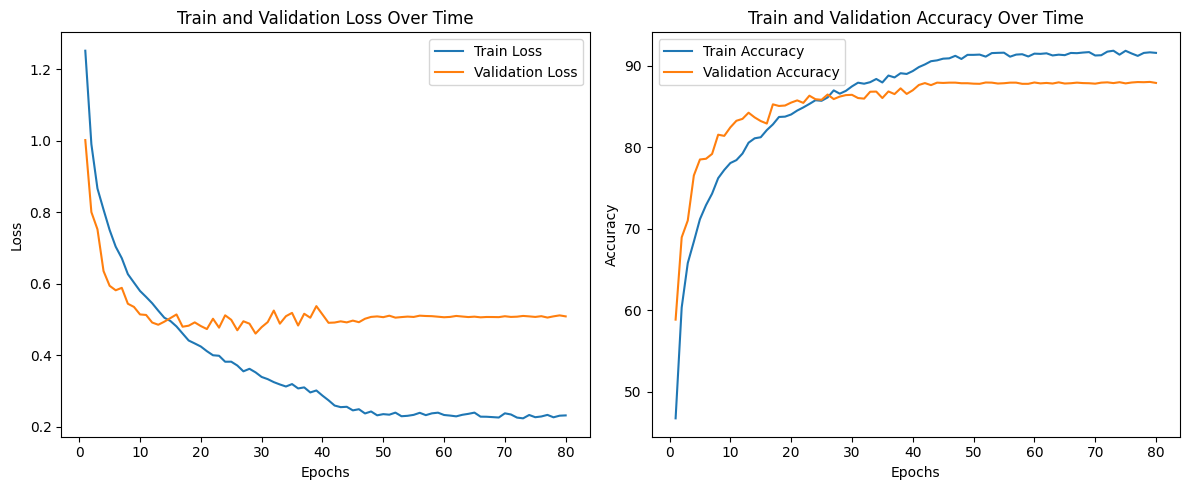

In [ ]:
checkpoint_dir = 'mobilenet-split-1'
epochs, train_losses, val_losses, train_accs, val_accs = load_and_plot_metrics(checkpoint_dir)
# plot_metrics(epochs, train_losses, val_losses, train_accs, val_accs)

### Plot Confusion matrix

#### Chuẩn bị hàm để plot
Mô tả
* Hàm sẽ plot ra confusion matrix.
* Đồng thời xuất ra bảng giá trị precision, recall, F1 score cho từng label
* Sau cùng sẽ in ra accuracy cho danh sách các ảnh đã predict.
<br>

**Lưu ý: các ảnh không thể load được không được tính trong bảng này**

In [ ]:
def plot_metrics_and_confusion_matrix(csv_file, reverse_label_mapping):
    # Read the CSV file
    data = pd.read_csv(csv_file)

    # Ensure the relevant columns are present
    if 'label_idx' not in data.columns or 'predictions' not in data.columns:
        raise ValueError("CSV must contain 'label_idx' and 'predictions' columns.")

    # Get the true labels and predictions
    y_true = data['label_idx']
    y_pred = data['predictions']

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Get the labels for plotting
    labels = [reverse_label_mapping[i] for i in range(len(reverse_label_mapping))]

    # Calculate precision, recall, f1 score, and accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=list(reverse_label_mapping.keys()))
    accuracy = accuracy_score(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Label': labels,
        'Precision': [prec.round(4) for prec in precision],
        'Recall': [rec.round(4) for rec in recall],
        'F1 Score': [f1_score.round(4) for f1_score in f1],
    })

    # Plot the confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print("Metrics by Class over Loadable Images:")
    print(metrics_df)
    print(f"\nOverall Accuracy: {(accuracy*100):.4f}")


#### Confusion matrix cho SPLIT 1 và bảng các giá trị thống kê độ chính xác

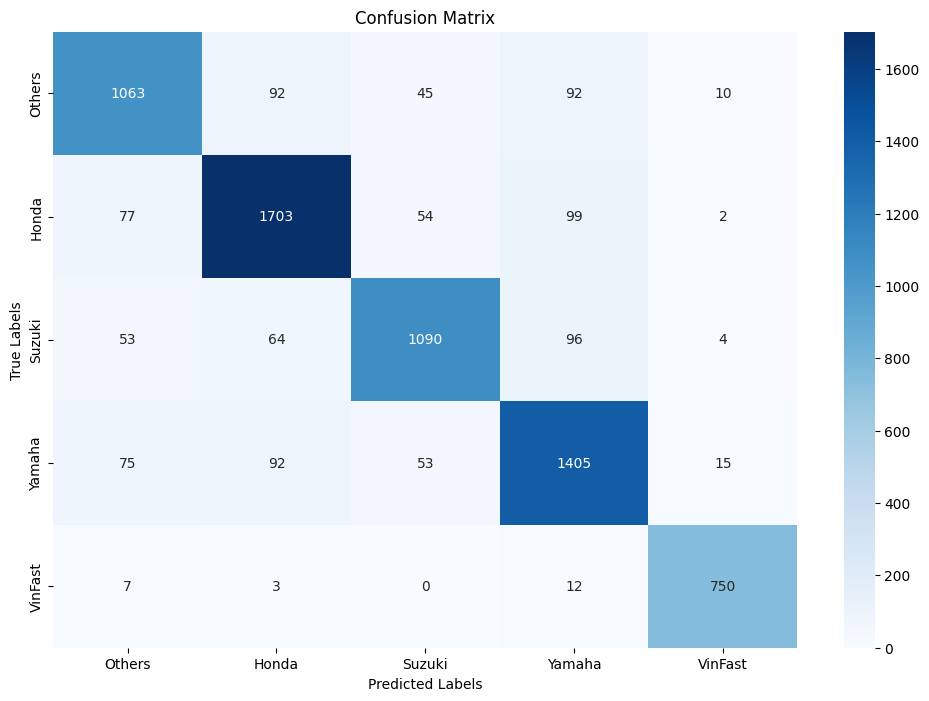

Metrics by Class over Loadable Images:
     Label  Precision  Recall  F1 Score
0   Others     0.8337  0.8164    0.8250
1    Honda     0.8715  0.8801    0.8758
2   Suzuki     0.8776  0.8340    0.8552
3   Yamaha     0.8245  0.8567    0.8403
4  VinFast     0.9603  0.9715    0.9659

Overall Accuracy: 86.4146


In [ ]:
csv_file = 'predictions-split-1.csv'
plot_metrics_and_confusion_matrix(csv_file, reverse_label_mapping)